In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import *
from sqlalchemy.sql import select
import seaborn as sns
from itertools import permutations
from tqdm import tqdm
from mpl_toolkits.basemap import Basemap
sns.set_style('white')
sns.set_context('poster')
sns.set_color_codes()
%matplotlib inline

We are going to load the database tables that were populated in populate_db.ipynb, calculate correlations, and put these correlations in another table in the same database.

In [2]:
engine = create_engine('sqlite:///airports.db')
conn = engine.connect()
meta = MetaData()
weather = Table('weather', meta, autoload=True, autoload_with=engine)
airports = Table('airports', meta, autoload=True, autoload_with=engine)

In [3]:
def correlate_high_temp(icao1, icao2, dt):
    """
    Calculates the correlation coefficient of the 1 day high temperature difference between the airports with
    ICAO codes icao1 and icao2, with icao2 delayed by dt days.
    """
    sel = select([weather.c.max_temp, weather.c.date])
    q1 = sel.where(weather.c.icao.like(icao1))
    q2 = sel.where(weather.c.icao.like(icao2))
    ht1 = np.array([ht[0] for ht in conn.execute(q1)])
    ht2 = np.array([ht[0] for ht in conn.execute(q2)])
    # Convert missing data to nan so that pandas can backfill this info
    ht1[ht1==''] = np.nan
    ht2[ht2==''] = np.nan
    data = list(zip(*[ht1, ht2]))
    df = pd.DataFrame(data=data, 
                      columns=[icao1, icao2],
                      dtype=(float, float))
    return np.corrcoef(np.array(df[icao1].diff(1).bfill()), np.array(df[icao2].diff(1).shift(dt).bfill()))[0,1]

We can test this by looking at a few airports where we know what to expect. Newark and JFK are very close, so their same-day high temperature differences should be highly correlated. There is a strong jet stream that flows west to east between Chicago and New York, so we might expect a fairly strong correlation in temperature changes in New York with Chicago laggin by one day. The reverse would not be true, based on the direction of the weather pattern. Temperature changes in New York and San Francisco should be uncorrelated. 

In [6]:
print('KEWR to KJFK, 0 days:', correlate_high_temp('KEWR', 'KJFK', 0))
print('KJFK to KORD, 1 days:',correlate_high_temp('KJFK', 'KORD', 1))
print('KORD to KJFK, 1 days:',correlate_high_temp('KORD', 'KJFK', 1))
print('KJFK to KSFO, 1 days:',correlate_high_temp('KJFK', 'KSFO', 0))

KEWR to KJFK, 0 days: 0.880172543693
KJFK to KORD, 1 days: 0.411067088119
KORD to KJFK, 1 days: -0.138824054625
KJFK to KSFO, 1 days: -0.00727817504884


In [7]:
def correlate_precip(icao1, icao2, dt):
    sel = select([weather.c.precip, weather.c.date])
    q1 = sel.where(weather.c.icao.like(icao1))
    q2 = sel.where(weather.c.icao.like(icao2))
    p1 = np.array([p[0] for p in conn.execute(q1)])
    p2 = np.array([p[0] for p in conn.execute(q2)])
    p1[p1=='T'] = '0.00'
    p2[p2=='T'] = '0.00'
    data = list(zip(*[p1, p2]))    
    df = pd.DataFrame(data=data,
                      columns=[icao1, icao2],
                      dtype=(float, float))
    return np.corrcoef(np.array(df[icao1].diff(1).bfill()), np.array(df[icao2].diff(1).shift(dt).bfill()))[0,1]

In [9]:
print('KEWR to KJFK, 0 days:', correlate_precip('KEWR', 'KJFK', 0))
print('KJFK to KORD, 1 days:',correlate_precip('KJFK', 'KORD', 1))
print('KORD to KJFK, 1 days:',correlate_precip('KORD', 'KJFK', 1))
print('KJFK to KSFO, 1 days:',correlate_precip('KJFK', 'KSFO', 0))

KEWR to KJFK, 0 days: 0.831579457296
KJFK to KORD, 1 days: 0.0717356982053
KORD to KJFK, 1 days: 0.0135544198285
KJFK to KSFO, 1 days: -0.0058837730335


Define new table for the correlation data

In [10]:
meta = MetaData()
corr_table = Table('correlations', meta,
                      Column('icao1', String),
                      Column('icao2', String),
                      Column('high_temp_1', Float),
                      Column('high_temp_3', Float),
                      Column('high_temp_7', Float),
                      Column('precip_1', Float),
                      Column('precip_3', Float),
                      Column('precip_7', Float), extend_existing=True)

In [14]:
try:
    corr_table.create(bind=engine)
except:
    print('Table already exists in DB')

Table already exists in DB


In [15]:
airport_list = [r[0] for r in conn.execute(select([airports.c.ICAO]))]

Now we fill this new table

# Warning: takes ~30 minutes to run

In [13]:
pairs = list(permutations(airport_list, 2))
for p in tqdm(pairs):
    ht1 = correlate_high_temp(p[0], p[1], 1)
    ht3 = correlate_high_temp(p[0], p[1], 3)
    ht7 = correlate_high_temp(p[0], p[1], 7)
    p1 = correlate_precip(p[0], p[1], 1)
    p3 = correlate_precip(p[0], p[1], 3)
    p7 = correlate_precip(p[0], p[1], 7)
    ins = corr_table.insert().values(icao1=p[0], 
                                     icao2=p[1], 
                                     high_temp_1=ht1, 
                                     high_temp_3=ht3, 
                                     high_temp_7=ht7,
                                     precip_1=p1,
                                     precip_3=p3,
                                     precip_7=p7)
    conn.execute(ins)

100%|██████████| 2450/2450 [30:47<00:00,  1.33it/s]


# Making sense of the data

In [16]:
def get_lat_long(icao):
    """
    Get the latitude and longitude of an airport
    """
    sel = select([airports.c.latitude_deg, airports.c.longitude_deg])
    q = sel.where(airports.c.ICAO.like(icao))
    q = q.order_by(func.abs(airports.c.longitude_deg))
    results = conn.execute(q).fetchall()
    return results[0]

In [17]:
def get_dlat_dlong(icao1, icao2):
    """
    Get the differences in latitude and longitude between two airports
    """
    lat1, long1 = get_lat_long(icao1)
    lat2, long2 = get_lat_long(icao2)
    return lat1-lat2, long1-long2

In [25]:
def get_distance(icao1, icao2):
    """
    Use the Haversine formula to calculate the distance between two airports
    """
    lat1, long1 = np.deg2rad(get_lat_long(icao1))
    lat2, long2 = np.deg2rad(get_lat_long(icao2))
    # Use Haversine formula to obtain distances
    a = np.sin((lat2-lat1)/2.)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((long2-long1)/2.)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1.-a))
    R = 6371 # Earth's radius in km
    d = R * c
    return d

In [26]:
def get_top(col_name, n=0):
    """
    Get the airport ICAO codes and correlation coefficients of col_name (one of high_temp_x or precip_x for 
    x in 1, 3, 7) for the n pairs with the largest correlations or anti-correlations. Results are sorted by
    the absolute value of the correlation coefficient in ascending order.
    """
    sel = select([corr_table.c.icao1, corr_table.c.icao2, corr_table.c.get(col_name)])
    q = sel.order_by(func.abs(corr_table.c.get(col_name)))
    results = conn.execute(q).fetchall()
    return results[-n:]

In [27]:
def plot(col_name, n=0, title='', save=None):
    """
    Plots the correlation coefficient for col_name as functions of distance, change in latitude,
    and change in longitude.
    """
    icao1, icao2, corr = zip(*get_top(col_name, n))
    pairs = list(zip(icao1, icao2))
    dist = [get_distance(*p) for p in pairs]
    dlat, dlong = list(zip(*[get_dlat_dlong(*p) for p in pairs]))
    plt.figure(figsize=(12, 15))
    plt.subplot(311)
    plt.scatter(dist, corr)
    plt.title(title)
    plt.xlim(0, 10000)
    plt.xlabel('Distance (km)')
    plt.subplot(312)
    plt.scatter(dlat, corr)
    plt.ylabel('Correlation coefficent')
    plt.xlabel('$\Delta$ latitude (degrees)')
    plt.subplot(313)
    plt.scatter(dlong, corr)
    plt.xlabel('$\Delta$ longitude (degrees)')
    if save is not None:
        plt.savefig(save, bbox_inches='tight')

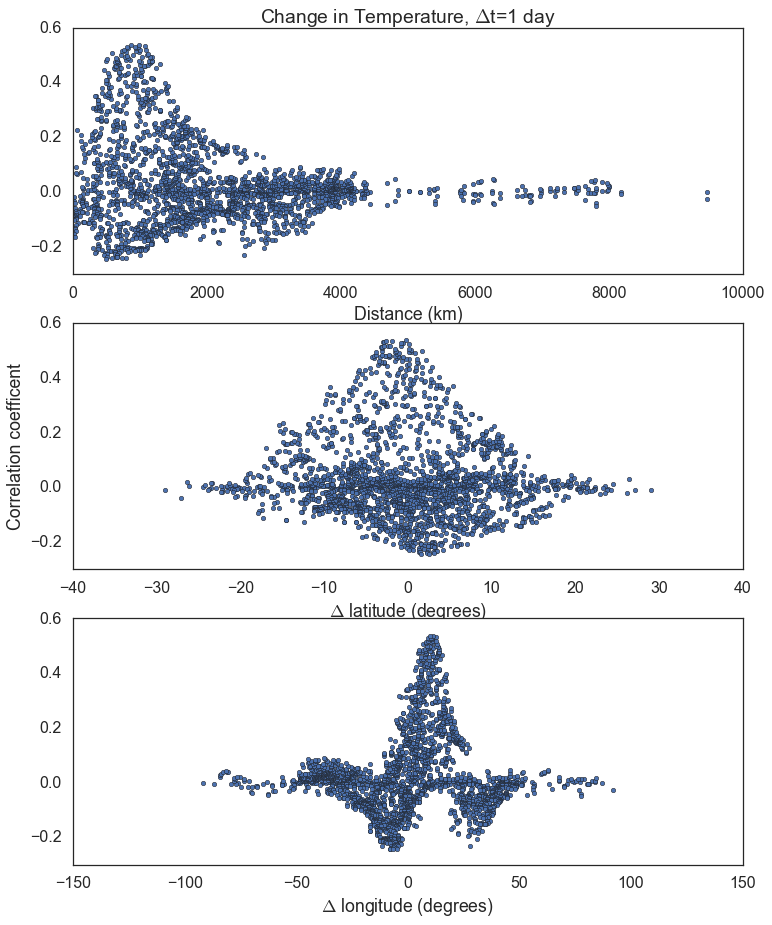

In [28]:
plot('high_temp_1', title='Change in Temperature, $\Delta$t=1 day')

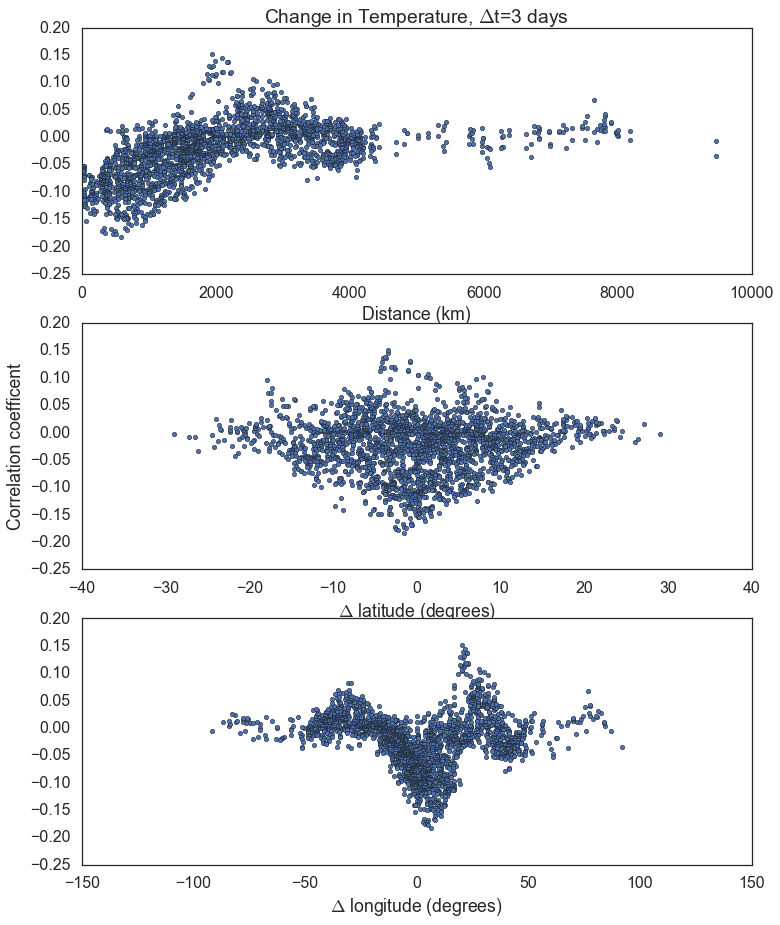

In [29]:
plot('high_temp_3', title='Change in Temperature, $\Delta$t=3 days')

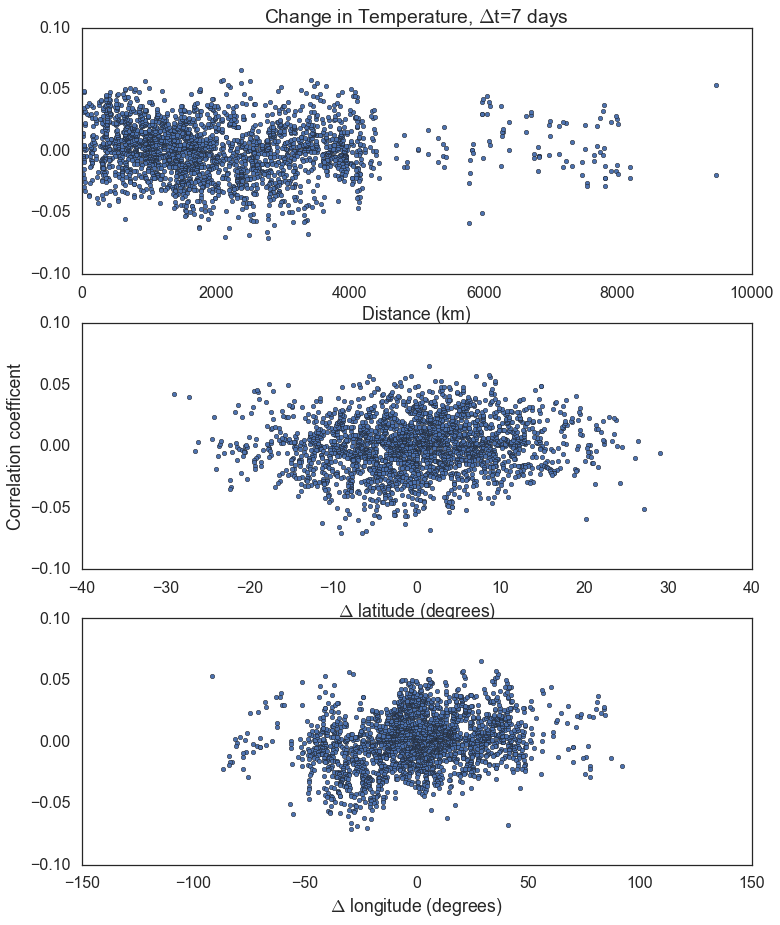

In [30]:
plot('high_temp_7', title='Change in Temperature, $\Delta$t=7 days')

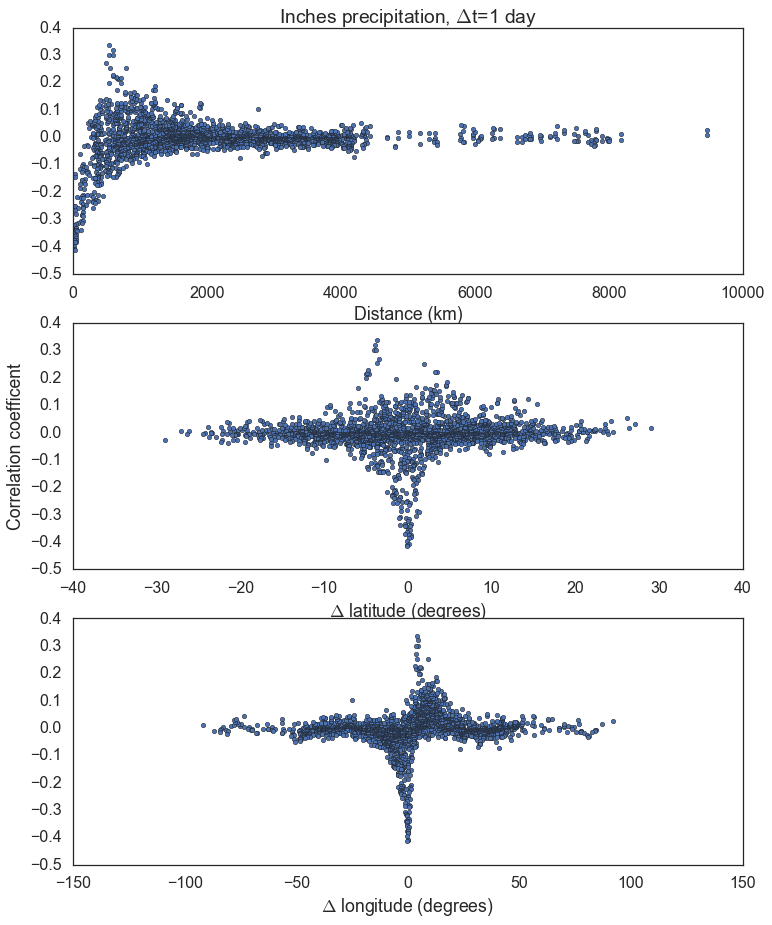

In [31]:
plot('precip_1', title='Inches precipitation, $\Delta$t=1 day')

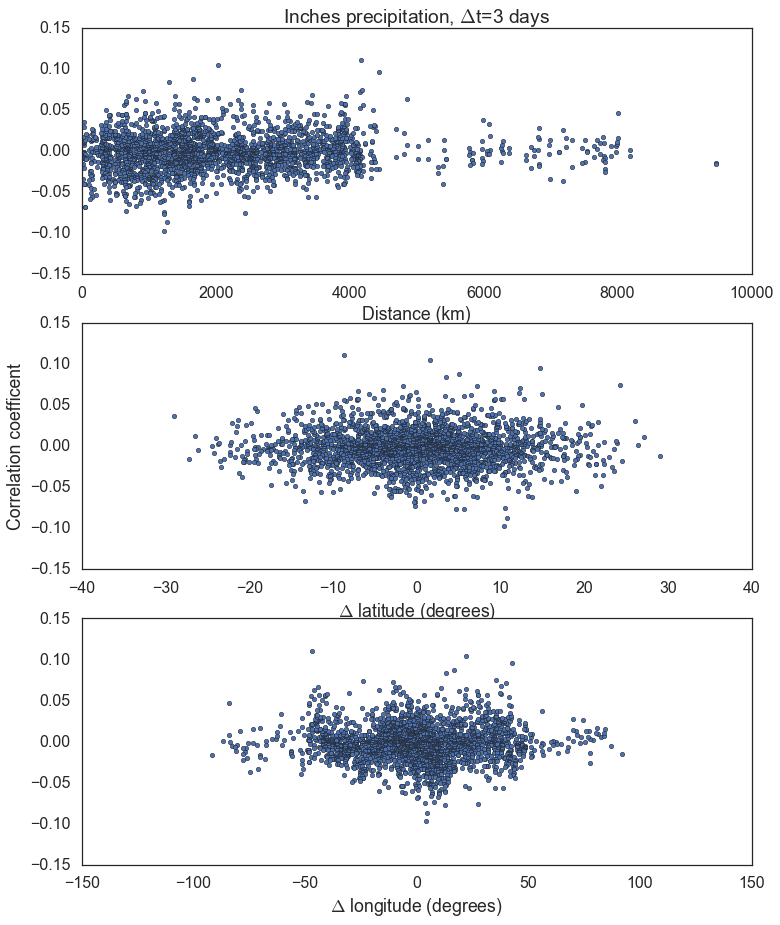

In [32]:
plot('precip_3', title='Inches precipitation, $\Delta$t=3 days')

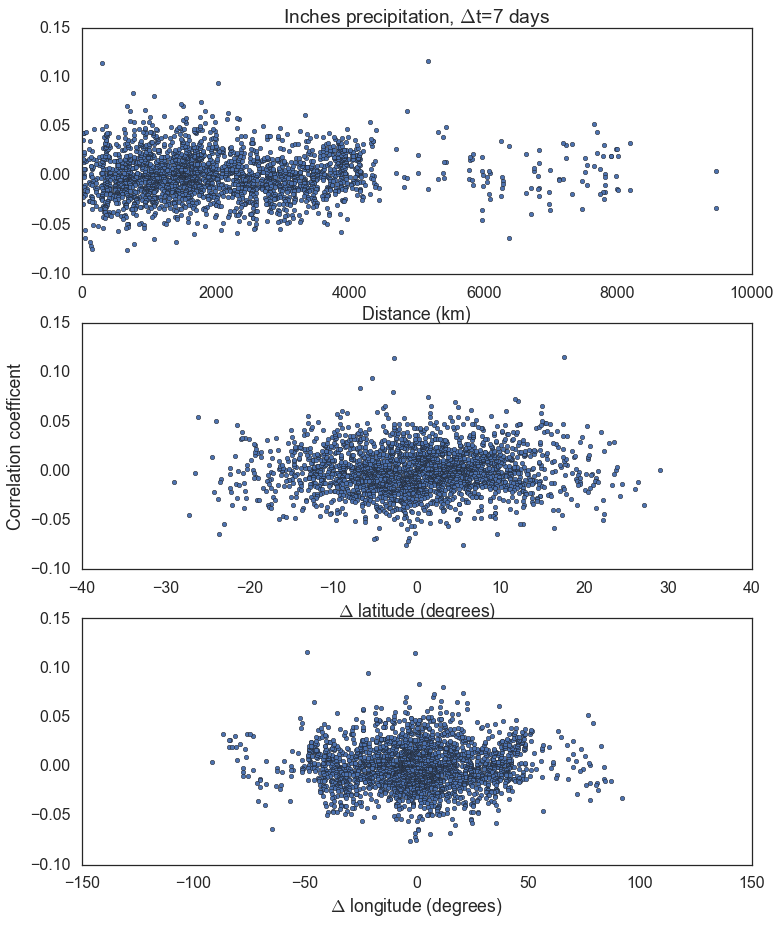

In [33]:
plot('precip_7', title='Inches precipitation, $\Delta$t=7 days')

# On the map

In [34]:
m = Basemap(projection='lcc', llcrnrlon=-130, llcrnrlat=20,
            urcrnrlon=-60, urcrnrlat=50,
            lat_1=35, lon_0=-100,
            resolution ='l',area_thresh=1000.)

In [59]:
def plot_paths(col_name, n=0, title='', save=None):
    """
    Plot the paths between airports colored by their correlation coefficients
    """
    icao1, icao2, corr = zip(*get_top(col_name, n))
    colormap = plt.cm.bwr(np.linspace(0, 1, 1000))
    plt.figure(figsize=(12, 9))
    for i1, i2, c in zip(icao1, icao2, corr):
        lat1, long1 = get_lat_long(i1)
        lat2, long2 = get_lat_long(i2)
        col = colormap[int((c+1)*500)]
        m.plot((long1, long2), (lat1, lat2), latlon=True, color=col, linewidth=1)
    for i in airport_list:
        lat, long = get_lat_long(i)
        m.plot(long, lat, latlon=True, color='k', marker='o', markersize=8)
    m.bluemarble()
    m.drawcountries()
    m.drawcoastlines()
    m.drawstates()
    plt.title(title)
    if save is not None:
        plt.savefig(save, bbox_inches='tight')

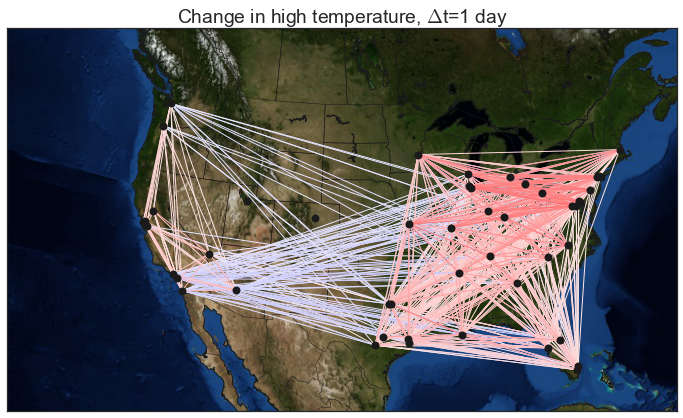

In [53]:
plot_paths('high_temp_1', n=1000, title='Change in high temperature, $\Delta$t=1 day')

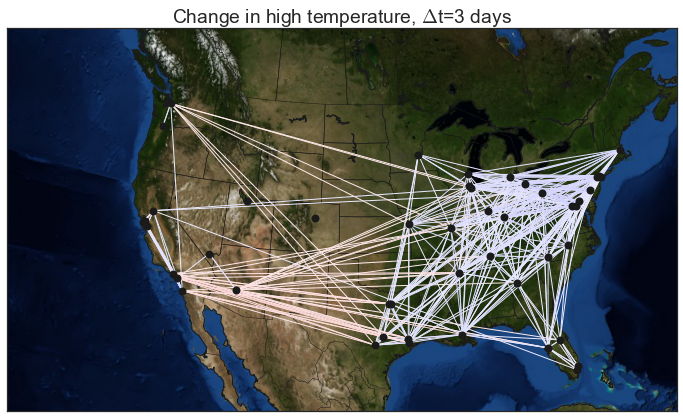

In [54]:
plot_paths('high_temp_3', n=500, title='Change in high temperature, $\Delta$t=3 days')

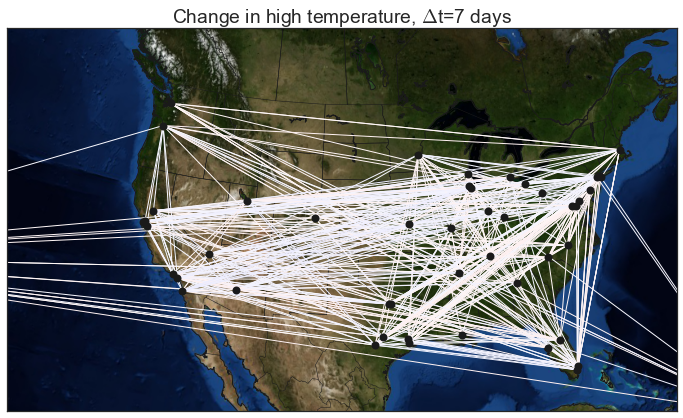

In [55]:
plot_paths('high_temp_7', n=500, title='Change in high temperature, $\Delta$t=7 days')

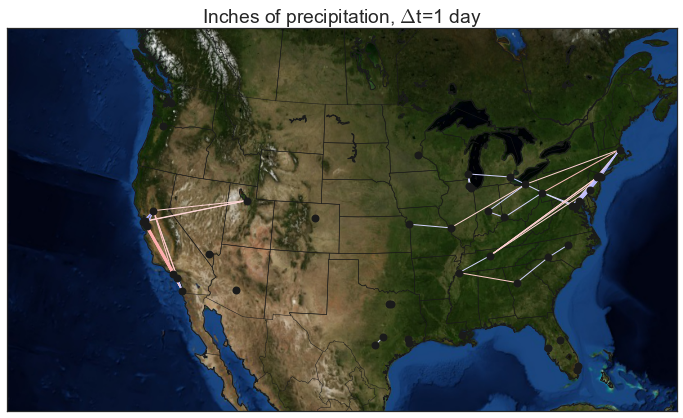

In [56]:
plot_paths('precip_1', n=100, title='Inches of precipitation, $\Delta$t=1 day')

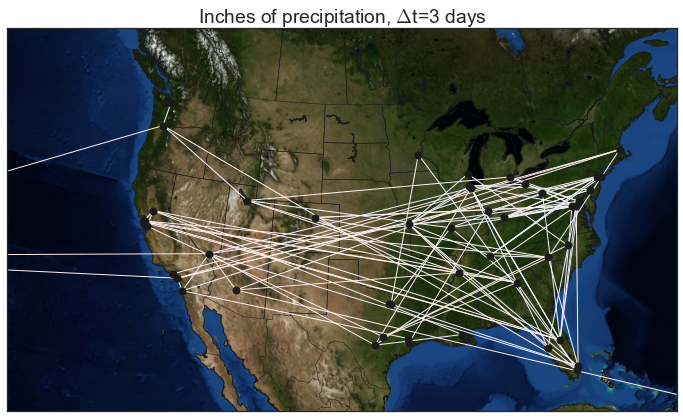

In [57]:
plot_paths('precip_3', n=100, title='Inches of precipitation, $\Delta$t=3 days')

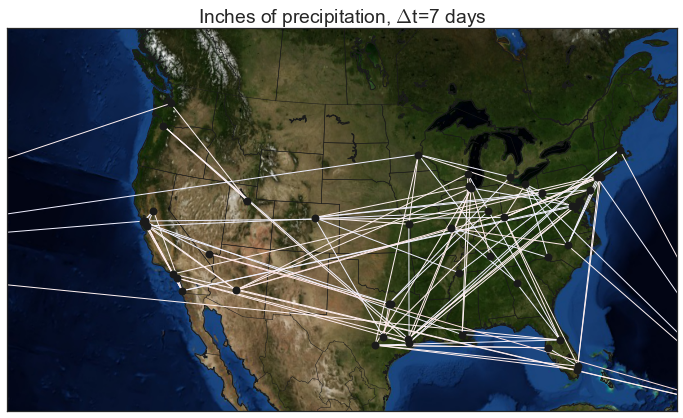

In [58]:
plot_paths('precip_7', n=100, title='Inches of precipitation, $\Delta$t=7 days')

# Conclusions

We can see a few patterns taking shape in these plots.

Precipitation correlates only over very short distances and on time scales of about 1 day. Looking at the correlation coefficient for a time delay of one day as a function of change in longitude, we see that precipitation values go from being anti-correlated to correlated as the change in longitude crosses from negative to positive values. This would suggest that precipitation flows from west to east.

The day-to-day change in high temperature correlates over much larger distances and over longer time scales -- we can see structure in the plot of correlation coefficient vs distance for $\Delta$t=3 days. For $\Delta$t=1 day, the strongest correlation coefficients occur when the change in longitude is approximately 10 degrees. There are also relatively strong anti-correlations at when the change in longitude is -5 degrees and 30 degrees. The locations of the anti-correlations at $\Delta$t=1 day become correlations at $\Delta$t=3 days.